<html>
<body>
<h1 style = "color:blue"> Classify Euro coins into three different categories</h1>

<h2 style = "color:red"> Abstract: </h2>
<p>The goal of this notebook is to build a convNN clasification using Tensor Flow library that is desinged to classify a given image of an euro coin into four different categories:.</p>
<p> a) Categorie 0 = 2 euro, 1 euro, or no euro. </p>
<p> b) Categorie 1 = 50 cent, 20 cent, 10 cent. </p>
<p> c) Categorie 2 = 5 cent, 2 cent, 1 cent. </p>

<h2 style = "color:red"> Dataset: </h2>
<p>The dataset employed in the training process is given by the Euro Coin dataset.</p>
</body>
</html>


In [1]:
import os, cv2, random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from coins_utils import *
    
#TRAIN_DIR = 'CandidateDataSet2/Augmented_and_Resized_RAW/all/' #For only rotations
#TRAIN_DIR = 'CandidateDataSet2/augmented_and_resized_brightness_yuv_RAW/all/' #For rotations and brightness
TRAIN_DIR = 'CandidateDataSet2/resized_150_yuv_RAW/all/' #For rotations and brightness

ROWS = 150
COLS = 150
CHANNELS = 3

images_full = [TRAIN_DIR+i for i in os.listdir(TRAIN_DIR) if '.jpg' in i]
random.shuffle(images_full)
n_images = len(images_full)
print("Number of images in full dataset "+str(n_images))
print("------------------------------------")


#Splitting of the input dataset into train, validation and test set.
train_to_full = 0.6 # Fraction of images used for training
validation_to_full = 0.8 # Fraction of images used for validation
train_to_full_index = int(n_images*train_to_full)
validation_to_full_index = int(n_images*validation_to_full)

#train_images = sorted(images_full[:train_to_full_index])
#validation_images =  sorted(images_full[train_to_full_index:validation_to_full_index])
#test_images =  sorted(images_full[validation_to_full_index:])

train_images = images_full[:train_to_full_index]
validation_images =  images_full[train_to_full_index:validation_to_full_index]
test_images =  images_full[validation_to_full_index:]

n_train_images = len(train_images)
n_validation_images = len(validation_images)
n_test_images = len(test_images)

print("Total number of train images "+str(n_train_images))
print("Total number of validation images "+str(n_validation_images))
print("Total number of test images "+str(n_test_images))
if n_train_images+n_validation_images+n_test_images - n_images != 0:
    print("Warning, there is a problem in the splitting of images")

#train = prep_data(train_images, ROWS = ROWS, COLS = COLS, colorSpace = "YUV")
#validation = prep_data(validation_images, ROWS = ROWS, COLS = COLS, colorSpace = "YUV")
#test = prep_data(test_images, ROWS = ROWS, COLS = COLS, colorSpace = "YUV")

train,maxTrain,minTrain = prep_data_nomean(train_images, ROWS = ROWS, COLS = COLS, colorSpace = "YUV")
validation = prep_data_nomean_test(validation_images, maxTrain, minTrain, ROWS = ROWS, COLS = COLS, colorSpace = "YUV")
test = prep_data_nomean_test(test_images, maxTrain, minTrain, ROWS = ROWS, COLS = COLS, colorSpace = "YUV")

#To make them easier to operate in future
train_images_name = [i.split('/')[-1] for i in train_images]
validation_images_name = [i.split('/')[-1] for i in validation_images]
test_images_name = [i.split('/')[-1] for i in test_images]
print(len(train_images_name), len(validation_images_name), len(test_images_name))

Using TensorFlow backend.


Number of images in full dataset 18147
------------------------------------
Total number of train images 10888
Total number of validation images 3629
Total number of test images 3630
Processed 0 of 10888
Processed 1000 of 10888
Processed 2000 of 10888
Processed 3000 of 10888
Processed 4000 of 10888
Processed 5000 of 10888
Processed 6000 of 10888
Processed 7000 of 10888
Processed 8000 of 10888
Processed 9000 of 10888
Processed 10000 of 10888
Processed 0 of 3629
Processed 1000 of 3629
Processed 2000 of 3629
Processed 3000 of 3629
Processed 0 of 3630
Processed 1000 of 3630
Processed 2000 of 3630
Processed 3000 of 3630
10888 3629 3630


# Getting the LABELS

In [2]:
## read the labels.
labels = pd.read_csv(TRAIN_DIR+'/labels_all.csv')

labels_train_df = labels[labels["FileName"].isin(train_images_name)]
labels_validation_df = labels[labels["FileName"].isin(validation_images_name)]
labels_test_df = labels[labels["FileName"].isin(test_images_name)]


#Example get the Group field and create array with labels (This is not very efficient...)
nb_classes = 3
#labels_train_nocategorical = []
labels_train_nocategorical = len(train_images_name)*[None]
k = 0
for kitem in train_images_name:
        labels_train_nocategorical[k] = labels[labels["FileName"] == kitem].iloc[0][2]
        k += 1
        #labels_train_nocategorical.append(labels[labels["FileName"] == kitem].iloc[0][2])
labels_train_nocategorical= np.array(labels_train_nocategorical)
print('Train set labels read!')
    
#labels_validation_nocategorical = []
labels_validation_nocategorical = len(validation_images_name)*[None]
k = 0
for kitem in validation_images_name:
        labels_validation_nocategorical[k] = labels[labels["FileName"] == kitem].iloc[0][2]
        k += 1
        #labels_validation_nocategorical.append(labels[labels["FileName"] == kitem].iloc[0][2])      
labels_validation_nocategorical= np.array(labels_validation_nocategorical)
print('Validation set labels read!')

labels_test_nocategorical = []
labels_test_nocategorical = len(test_images_name)*[None]
k = 0
for kitem in test_images_name:
        labels_test_nocategorical[k] = labels[labels["FileName"] == kitem].iloc[0][2]
        k += 1
        #labels_test_nocategorical.append(labels[labels["FileName"] == kitem].iloc[0][2])      
labels_test_nocategorical= np.array(labels_test_nocategorical)
print('Test set labels read!')


#Convert to categorical labels (vectors)
from keras.utils import np_utils
labels_train = np_utils.to_categorical(labels_train_nocategorical, nb_classes)
labels_validation = np_utils.to_categorical(labels_validation_nocategorical, nb_classes)
labels_test = np_utils.to_categorical(labels_test_nocategorical, nb_classes)

Train set labels read!
Validation set labels read!
Test set labels read!


# Sanity check, we are reading everything properly

In [ ]:
#Print some coins
def printSomeCoints(img, train_images_name, labels, ncoins):
    for i in range(0,ncoins):
        print(train_images_name[i])
        if labels[i] == 0.:
            print("This is 1 euro or 2 euro")
        if labels[i] == 1.:
            print("This is 50, 20 or 10 cent")
        if labels[i] == 2.:
            print("This is 5, 2, 1 cent")
        plt.figure(figsize=(10,5))
        print(train[i].shape)
        plt.imshow(cv2.cvtColor(train[i], cv2.COLOR_YUV2RGB))
        plt.show()
    
    
printSomeCoints(train, train_images_name, labels_train_nocategorical, 30)

<html>
<body>
<h2 style = "color:red"> Building the classificator (work in progress..): </h2>
<p> Use the training dataset to build the classificator using a ConvNN.</p>
</body>
</html>

In [3]:
#Loading keras deep learnig libraries to build the model: https://keras.io/ 
from keras.layers import Input, Dense, Flatten, Dropout, Activation, advanced_activations, Convolution2D, MaxPooling2D
from keras.models import Model, model_from_json
from keras.optimizers import RMSprop
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras import initializations

In [ ]:
#Model hyperparameters
batch_size = 32 # in each iteration, we consider batch_size training examples at once
num_epochs = 15 # we iterate num_epochs times over the entire training set
kernel_size = 3 # we will use 3x3 kernels throughout
pool_size = 2 # we will use 2x2 pooling throughout
conv_depth_1 = 32 # we will initially have 32 kernels per conv. layer...
conv_depth_2 = 62 # ...switching to 64 after the first pooling layer
conv_depth_3 = 128 # ...switching to 64 after the first pooling layer
conv_depth_4 = 256 # ...switching to 64 after the first pooling layer
conv_depth_5 = 512 # ...switching to 64 after the first pooling layer
drop_prob_1 = 0.25 # dropout after pooling with this probability 
drop_prob_2 = 0.5 # dropout in the FC layer with this probability 
hidden_size = 32 # the FC layer will this neurons
data_augmentation = False # Whether to use or not data augmentation

NN = False
ConvNN = True
if ConvNN == True:
    #Architecture
    inp = Input(shape=(ROWS, COLS, CHANNELS)) # N.B. depth goes first in Keras!
    conv_1 = Convolution2D(conv_depth_1, kernel_size, kernel_size, border_mode='same', activation='relu')(inp)
    pool_1 = MaxPooling2D(pool_size=(pool_size, pool_size))(conv_1)
    conv_2 = Convolution2D(conv_depth_2, kernel_size, kernel_size, border_mode='same', activation='relu')(pool_1)
    pool_2 = MaxPooling2D(pool_size=(pool_size, pool_size))(conv_2)
    conv_3 = Convolution2D(conv_depth_3, kernel_size, kernel_size, border_mode='same', activation='relu')(pool_2)
    pool_3 = MaxPooling2D(pool_size=(pool_size, pool_size))(conv_3)
    conv_4 = Convolution2D(conv_depth_4, kernel_size, kernel_size, border_mode='same', activation='relu')(pool_3)
    pool_4 = MaxPooling2D(pool_size=(pool_size, pool_size))(conv_4)
    conv_5 = Convolution2D(conv_depth_5, kernel_size, kernel_size, border_mode='same', activation='relu')(pool_4)
                       

    flat = Flatten()(conv_5)
    hidden = Dense(hidden_size, activation='sigmoid')(flat)
    out = Dense(nb_classes, activation='sigmoid')(hidden)
    model = Model(input=inp, output=out) # To define a model, just specify its input and output layers

if NN == True:
    #Architecture
    inp = Input(shape=(ROWS, COLS, CHANNELS)) # N.B. depth goes first in Keras!                  
    flat = Flatten()(inp)
    hidden = Dense(hidden_size, activation='tanh')(flat)
    out = Dense(nb_classes, activation='sigmoid')(hidden)
    model = Model(input=inp, output=out) # To define a model, just specify its input and output layers

    
#print the summary of the architecture
model.summary()

#Visulize the model if desired
#from keras.utils.visualize_util import plot
#plot(model, to_file='Example_of_CNN_CatsVsDogs.pdf')

# reduce the learning rate by factor of 0.5 if the validation loss does not get lower in 7 epochs
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=0.0000001, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=1, mode='auto')


# Let's train the model using SGD
#model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])
#model.compile(loss='categorical_crossentropy', optimizer='adagrad', metrics=['accuracy'])
model.compile(loss='categorical_crossentropy', optimizer=RMSprop(lr=1e-4), metrics=['accuracy'])

# Let's train the SGD model WITHOUT using data augmentation
if not data_augmentation:
    print('Not using data augmentation.')
    history = model.fit(train, labels_train, batch_size=batch_size, nb_epoch=num_epochs, validation_data=(validation, labels_validation), shuffle=True, callbacks=[reduce_lr,early_stopping])
                       
                       

# Learning curves (check the performance)

In [ ]:
# list all data in history
print(history.history.keys())

# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
plt.savefig('Accuracy_Example_Coin_Classifier.pdf')
plt.close()


# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
plt.savefig('Loss_Example_Coin_Classifier.pdf')
plt.close()

# Save 

In [ ]:
SaveModel(model, "Model_Example_Coin_Classifier_150_norm_relu_yuv")

# Load and Test model

Loaded model Model_Example_Coin_Classifier_150_norm_relu_yuv from disk 

PREDICTIONS 

 0.00031939 of 1,2 euro 

 0.00069326 of 50,20,10 cent 

 0.94330972 of 5,2,1 



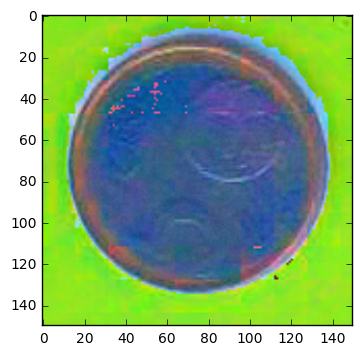

 0.86142039 of 1,2 euro 

 0.00113568 of 50,20,10 cent 

 0.00075530 of 5,2,1 



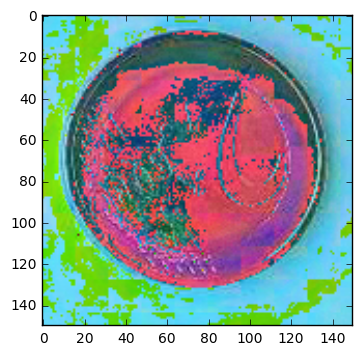

 0.00032040 of 1,2 euro 

 0.00068516 of 50,20,10 cent 

 0.94346333 of 5,2,1 



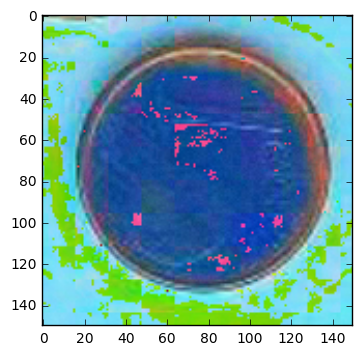

 0.00032038 of 1,2 euro 

 0.00068531 of 50,20,10 cent 

 0.94346005 of 5,2,1 



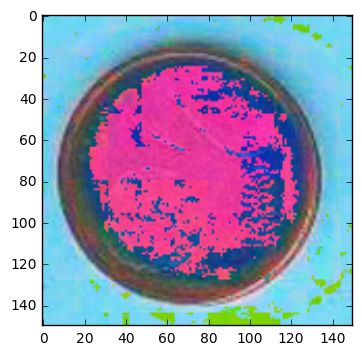

 0.00032040 of 1,2 euro 

 0.00068511 of 50,20,10 cent 

 0.94346464 of 5,2,1 



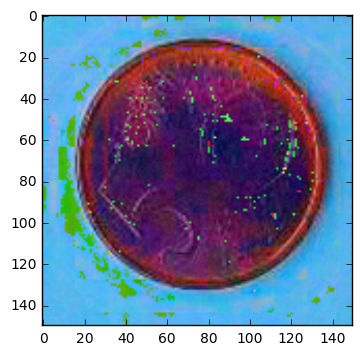

 0.00030234 of 1,2 euro 

 0.87666136 of 50,20,10 cent 

 0.00043511 of 5,2,1 



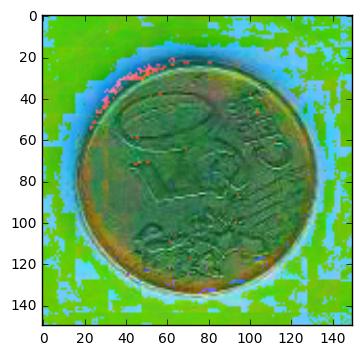

 0.00032051 of 1,2 euro 

 0.00068503 of 50,20,10 cent 

 0.94346046 of 5,2,1 



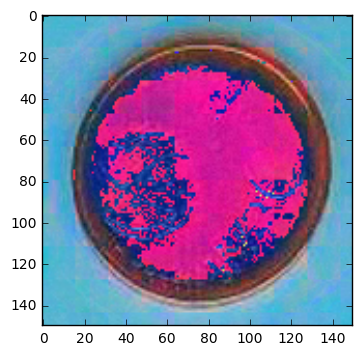

 0.00032035 of 1,2 euro 

 0.00068552 of 50,20,10 cent 

 0.94344699 of 5,2,1 



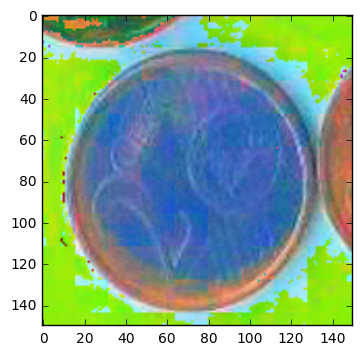

 0.00032040 of 1,2 euro 

 0.00068511 of 50,20,10 cent 

 0.94346464 of 5,2,1 



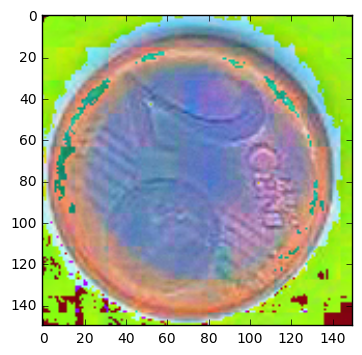

 0.00030901 of 1,2 euro 

 0.00077326 of 50,20,10 cent 

 0.94147867 of 5,2,1 



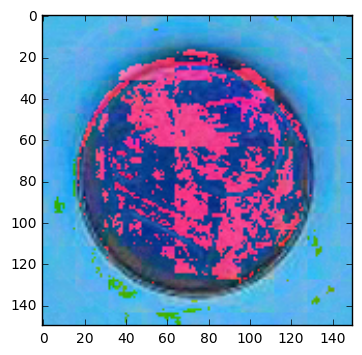

 0.00030234 of 1,2 euro 

 0.87666452 of 50,20,10 cent 

 0.00043510 of 5,2,1 



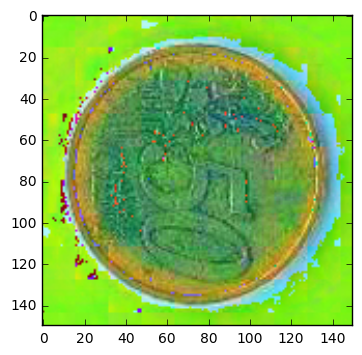

 0.86112416 of 1,2 euro 

 0.00113952 of 50,20,10 cent 

 0.00075477 of 5,2,1 



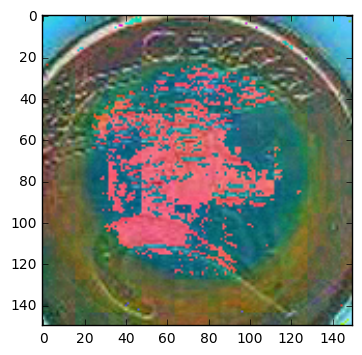

 0.00031999 of 1,2 euro 

 0.00068807 of 50,20,10 cent 

 0.94338322 of 5,2,1 



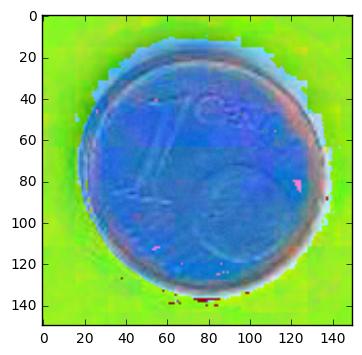

 0.00031963 of 1,2 euro 

 0.00069195 of 50,20,10 cent 

 0.94337249 of 5,2,1 



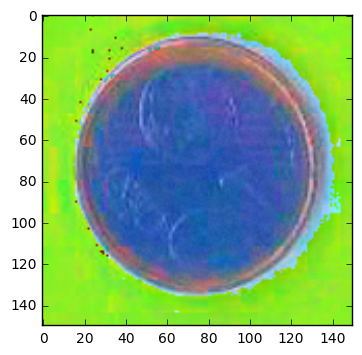

 0.00030251 of 1,2 euro 

 0.87648600 of 50,20,10 cent 

 0.00043518 of 5,2,1 



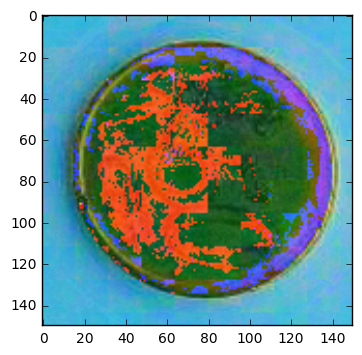

 0.00030233 of 1,2 euro 

 0.87664473 of 50,20,10 cent 

 0.00043520 of 5,2,1 



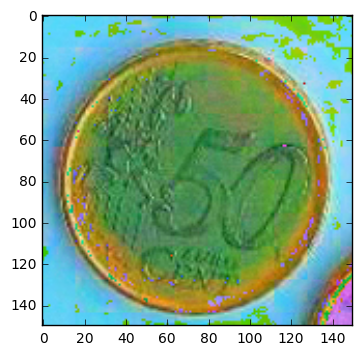

 0.00030266 of 1,2 euro 

 0.87635183 of 50,20,10 cent 

 0.00043554 of 5,2,1 



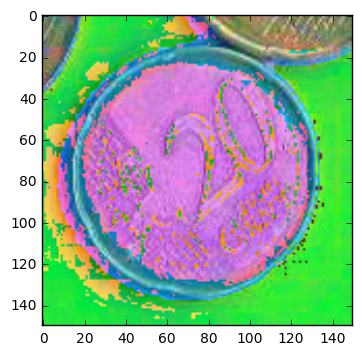

 0.00032040 of 1,2 euro 

 0.00068511 of 50,20,10 cent 

 0.94346452 of 5,2,1 



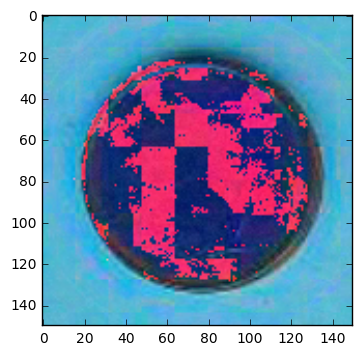

 0.00030267 of 1,2 euro 

 0.87643707 of 50,20,10 cent 

 0.00043524 of 5,2,1 



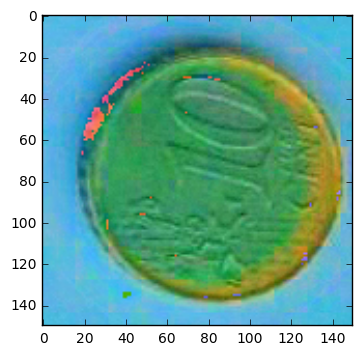

 0.00032040 of 1,2 euro 

 0.00068511 of 50,20,10 cent 

 0.94346464 of 5,2,1 



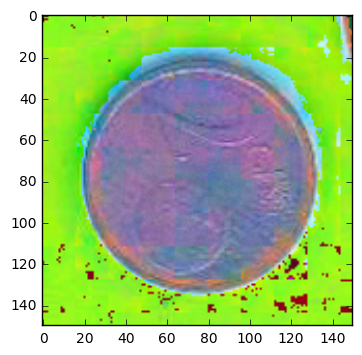

 0.00032040 of 1,2 euro 

 0.00068511 of 50,20,10 cent 

 0.94346464 of 5,2,1 



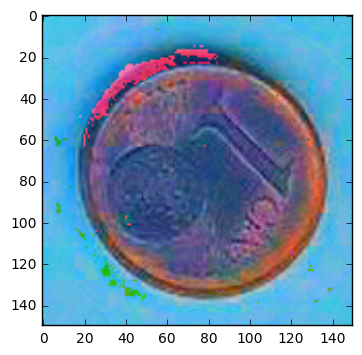

 0.00030235 of 1,2 euro 

 0.87665349 of 50,20,10 cent 

 0.00043511 of 5,2,1 



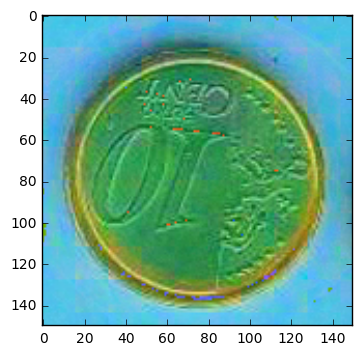

 0.86150920 of 1,2 euro 

 0.00113459 of 50,20,10 cent 

 0.00075551 of 5,2,1 



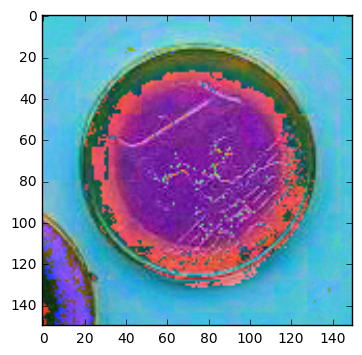

 0.00032040 of 1,2 euro 

 0.00068511 of 50,20,10 cent 

 0.94346464 of 5,2,1 



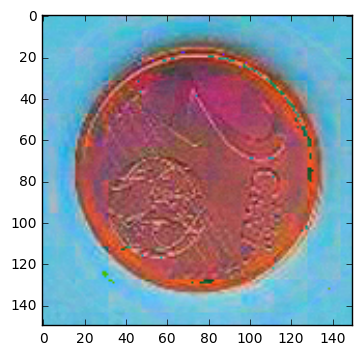

 0.86151034 of 1,2 euro 

 0.00113459 of 50,20,10 cent 

 0.00075551 of 5,2,1 



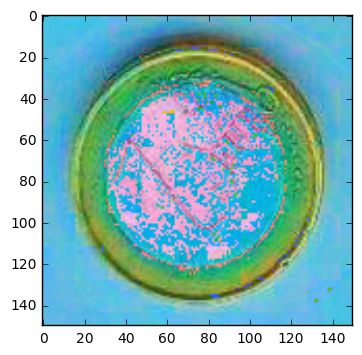

 0.00030234 of 1,2 euro 

 0.87666166 of 50,20,10 cent 

 0.00043510 of 5,2,1 



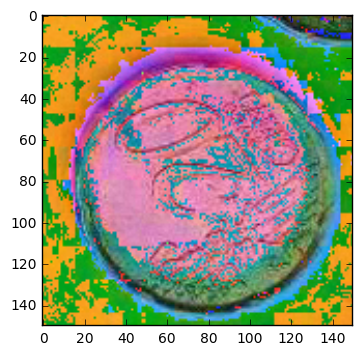

 0.86106467 of 1,2 euro 

 0.00113518 of 50,20,10 cent 

 0.00075599 of 5,2,1 



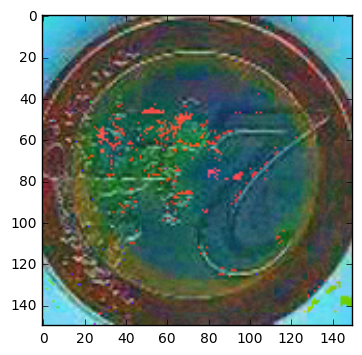

 0.00032040 of 1,2 euro 

 0.00068511 of 50,20,10 cent 

 0.94346464 of 5,2,1 



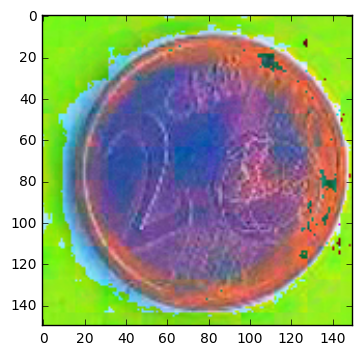

 0.00032040 of 1,2 euro 

 0.00068511 of 50,20,10 cent 

 0.94346440 of 5,2,1 



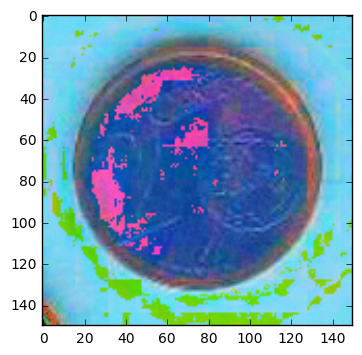

 0.00032040 of 1,2 euro 

 0.00068511 of 50,20,10 cent 

 0.94346464 of 5,2,1 



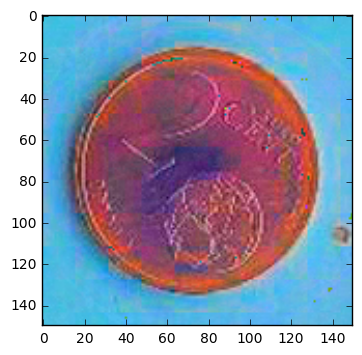

 0.86151052 of 1,2 euro 

 0.00113459 of 50,20,10 cent 

 0.00075551 of 5,2,1 



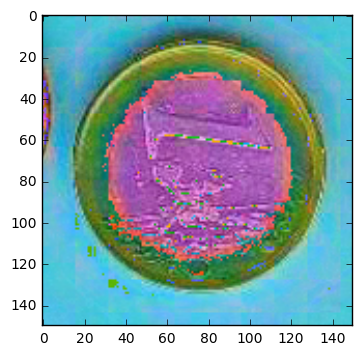

 0.86151046 of 1,2 euro 

 0.00113459 of 50,20,10 cent 

 0.00075551 of 5,2,1 



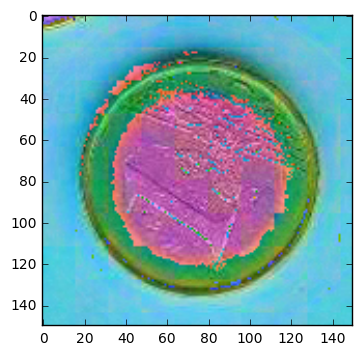

 0.85983914 of 1,2 euro 

 0.00113983 of 50,20,10 cent 

 0.00075674 of 5,2,1 



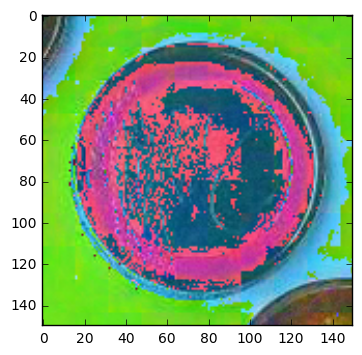

 0.00030474 of 1,2 euro 

 0.87627017 of 50,20,10 cent 

 0.00043471 of 5,2,1 



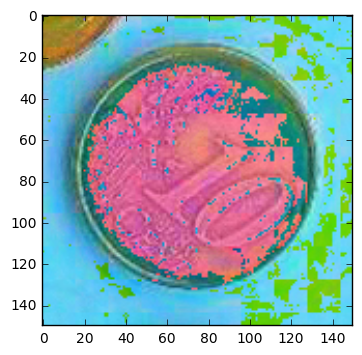

 0.00030237 of 1,2 euro 

 0.87664133 of 50,20,10 cent 

 0.00043513 of 5,2,1 



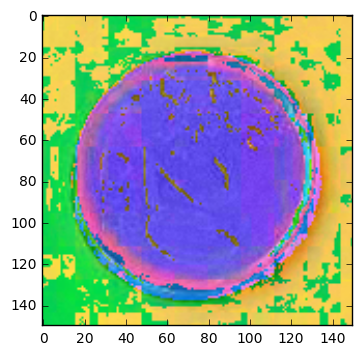

 0.00033877 of 1,2 euro 

 0.72782522 of 50,20,10 cent 

 0.00061338 of 5,2,1 



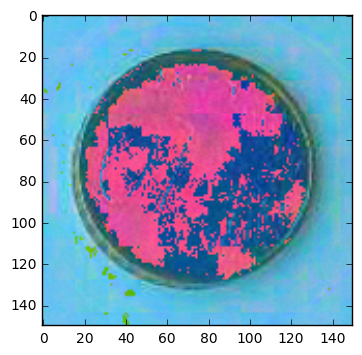

 0.00032865 of 1,2 euro 

 0.86553156 of 50,20,10 cent 

 0.00043884 of 5,2,1 



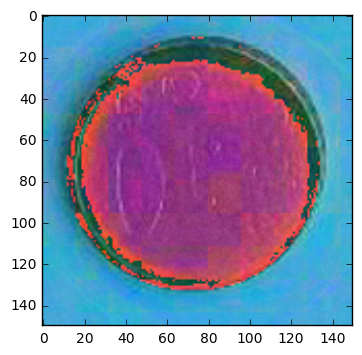

 0.00032040 of 1,2 euro 

 0.00068512 of 50,20,10 cent 

 0.94346386 of 5,2,1 



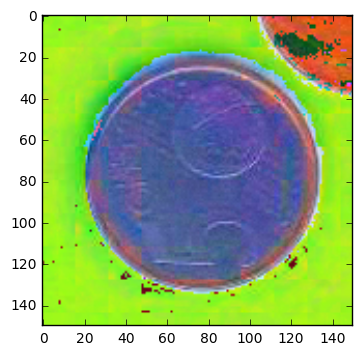

 0.00030234 of 1,2 euro 

 0.87666452 of 50,20,10 cent 

 0.00043510 of 5,2,1 



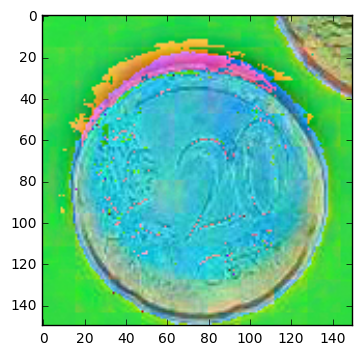

 0.00030234 of 1,2 euro 

 0.87666422 of 50,20,10 cent 

 0.00043510 of 5,2,1 



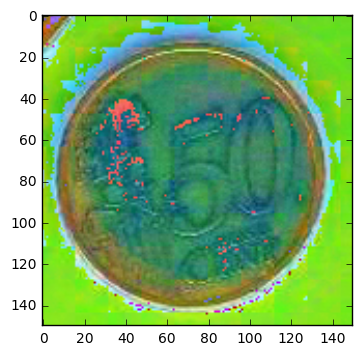

In [4]:
#Useful to test.
LoadAndTest = True
nTest = 40
if LoadAndTest == True:
    loaded_model=LoadModel("Model_Example_Coin_Classifier_150_norm_relu_yuv")  
    # evaluate loaded model on test data
    loaded_model.compile(loss='categorical_crossentropy', optimizer=RMSprop(lr=1e-4), metrics=['accuracy'])
    
    #score_train = loaded_model.evaluate(train, labels_train, verbose=0)
    #score_validation = loaded_model.evaluate(validation, labels_validation, verbose=0)
    #print "Training %s: %.2f%%" % (loaded_model.metrics_names[1], score_train[1]*100)
    #print "Validation %s: %.2f%%" % (loaded_model.metrics_names[1], score_validation[1]*100)    
    
    print("PREDICTIONS \n")
    reduced_test = test[:nTest]
    
    predictedLabel = loaded_model.predict(reduced_test)

    for i in range(0,nTest):
        print(" %.8f of 1,2 euro \n" % predictedLabel[i,0])
        print(" %.8f of 50,20,10 cent \n" % predictedLabel[i,1])
        print(" %.8f of 5,2,1 \n" % predictedLabel[i,2])
        plt.imshow(cv2.cvtColor(reduced_test[i], cv2.COLOR_YUV2RGB))
        plt.show()
    
        
    

In [ ]:
print(maxTest)